### In this notebook, we provide the hardcoded construction of a 3-layer BaseConv model that implements gradient descent on least squares.

In [1]:
# Imports
import sys
sys.path.append("/scratch/precision-ls/")
from munch import Munch
import numpy as np
import torch
from einops import einsum
import matplotlib.pyplot as plt

from src.models import build_model
from src.datagen.main import LeastSquaresSampler, ExplicitGradient

In [2]:
import matplotlib.colors as mcolors

def adjust_lightness(color, lightness):
    hsv = color.copy()
    hsv[2] = lightness
    return mcolors.hsv_to_rgb(hsv)

In [3]:
# Problem settings
n_dims = 5
n_points = 20
batch_size = 16

# Model settings
n_layer = 3
n_embd = 4*n_dims + 1
n_model_dims = n_dims + 1

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Gradient descent
lr = 0.1
num_iters = 300

Helpers for setting model parameters

In [4]:
# Manually initialize weights
def set_param(param, setting=None, bias=True, requires_grad=False, device="cuda"):
    if setting == "identity":
        param.weight = torch.nn.Parameter(torch.eye(*param.weight.shape).to(device))
        param.weight.requires_grad = requires_grad
        if bias:
            param.bias = torch.nn.Parameter(torch.zeros(*param.bias.shape).to(device))
            param.bias.requires_grad = requires_grad

    elif setting == "zeros":
        param.weight = torch.nn.Parameter(torch.zeros(*param.weight.shape).to(device))
        param.weight.requires_grad = requires_grad
        if bias:
            param.bias = torch.nn.Parameter(torch.zeros(*param.bias.shape).to(device))
            param.bias.requires_grad = requires_grad
            
    elif setting == "ones":
        param.weight = torch.nn.Parameter(torch.zeros(*param.weight.shape).to(device))
        param.weight.requires_grad = requires_grad
        if bias:
            param.bias = torch.nn.Parameter(torch.ones(*param.bias.shape).to(device))
            param.bias.requires_grad = requires_grad
            
    elif isinstance(setting, torch.Tensor):
        assert setting.shape == param.shape
        param.data = setting.clone().to(device)
        param.requires_grad = requires_grad

# These functions assume a Conv1d (i.e. "short") implementation of BaseConv
def set_conv_param(param, setting=None, requires_grad=False, device="cuda"):
    if setting == "identity":
        param.weight = torch.nn.Parameter(torch.zeros(*param.weight.shape).to(device))
        param.weight.data[..., -1] = 1
        param.bias.data = torch.nn.Parameter(torch.zeros(*param.bias.shape).to(device))
    elif setting == "zeros":
        param.weight.data = torch.nn.Parameter(torch.zeros(*param.weight.shape).to(device))
        param.bias.data = torch.nn.Parameter(torch.zeros(*param.bias.shape).to(device))
        
def initialize_weights(model, layer=None, setting=None, var=None, device="cuda"):

    if layer is None and setting is None:
        # Manually set weights
        set_param(model._read_in, setting="identity", device=device)
        set_param(model._read_out, setting="identity", device=device)
        set_param(model._backbone.transformer.wpe, setting="zeros", bias=False, device=device)


Data

In [5]:
# Sample data
sampler = LeastSquaresSampler(n_dims=n_dims, device=device)
a, x, x_init, b = sampler.sample(n_points=n_points, batch_size=batch_size)

task = ExplicitGradient(setting="last")
task_data = task.evaluate(sample_data=(a, x.clone(), x_init, b))
in_seq = task_data["in"][:, 1:]
out_grad = task_data["out"]

# Sanity check: Ax = b
print(torch.norm(torch.einsum("b l d, b d -> b l", a, x.squeeze(-1)) - b))

tensor(0., device='cuda:0')


### Gradient descent

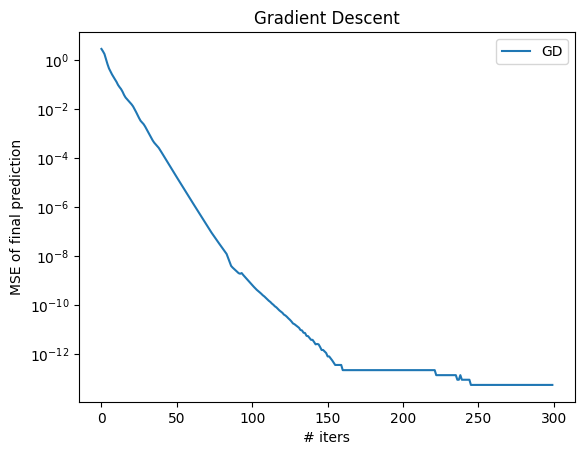

Final error: 5.684341886080802e-14


In [6]:
# Standard gradient descent
preds = []
pred_xs = []

layer_in = in_seq.clone()
x_pred = x_init

for iter_i in range(num_iters):
    grad = einsum(
        einsum(x_pred, a, "b d, b l d -> b l") - b, # (b l)
        a,
        "b l, b l d -> b d"
    ) * 2/(n_points)
    x_pred = x_pred - lr*grad
    pred = einsum(x_pred, a[:, -1], "b d, b d -> b")
    preds.append(pred)
    pred_xs.append(x_pred.clone())

preds = torch.stack(preds, dim=0) # (num_iters, B)
pred_xs = torch.stack(pred_xs, dim=0) # (num_iters, B, D)
errors = ((preds - b[:, -1])**2).detach().cpu().numpy() # (num_iters, B)
errors_gd_25 = np.percentile(errors, 25, axis=1)
errors_gd_75 = np.percentile(errors, 75, axis=1)
errors_gd = np.median(errors, axis=1)

plt.plot(errors_gd, label="GD")
plt.title("Gradient Descent")
plt.yscale("log")
plt.xlabel("# iters")
plt.ylabel("MSE of final prediction")
plt.legend()
plt.show()

print(f"Final error: {errors_gd[-1].item()}")

### Causal BaseConv model

In [7]:
def build_model_conf(
    n_layer=3,
    n_embd=128,
    n_dims=5,
    n_points=21,
):
    model_conf = Munch(
        family="gpt2",
        n_dims=n_dims,
        n_positions=n_points,
        n_embd=n_embd,
        n_layer=n_layer,
        n_head=1,
        use_mlps=False,
        seq_op="base_conv",
        mlp_activ="gelu",
        use_resid=False,
        use_seqop_ln=False,
        use_final_ln=False,
        use_mlp_ln=False,
        conv_type="short",
        causal=True,
        train_proj=False,
        train_pos=False,
        mlp_upfactor=2,
        in_dims=n_dims,
        out_dims=n_dims,
        use_softmax_for_attn=True,
    )
    return model_conf

In [8]:
model_conf = build_model_conf(
    n_layer=n_layer,
    n_embd=n_embd,
    n_dims=n_model_dims,
    n_points=n_points,
)

model = build_model(model_conf).to(device)
print(model)

Conv type = short
Conv type = short
Conv type = short
number of parameters: 0.01M
TransformerModel(
  (_read_in): Linear(in_features=6, out_features=21, bias=True)
  (_backbone): GPT2Model(
    (transformer): ModuleDict(
      (wpe): Embedding(20, 21)
      (drop): Dropout(p=0.0, inplace=False)
      (h): ModuleList(
        (0-2): 3 x Block(
          (ln_1): Identity()
          (seq_mixer): BaseConvLayer(
            (base_conv): BaseConv(
              (projection): Linear(in_features=21, out_features=21, bias=True)
              (in_proj): Linear(in_features=21, out_features=21, bias=True)
              (out_proj): Linear(in_features=21, out_features=21, bias=True)
              (conv): ShortConvolution(
                (conv): Conv1d(21, 21, kernel_size=(20,), stride=(1,), padding=(19,), groups=21)
              )
            )
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
      )
    )
  )
  (_read_out): Linear(in_features=21, out_features=6, bias=Tr

In [9]:
# Conv1d implementation

# Manually set model params

# Initial embed
initialize_weights(model)

# Layer 1
# In proj
# weight
temp = torch.zeros((n_embd, n_embd))
temp[2*n_dims+1:3*n_dims+1, :n_dims] = torch.eye(n_dims)
temp[:2*n_dims+1, :2*n_dims+1] = torch.eye(2*n_dims+1)
set_param(model._backbone.transformer.h[0].seq_mixer.base_conv.in_proj.weight, setting=temp, requires_grad=False, device=device)
# Conv
set_conv_param(model._backbone.transformer.h[0].seq_mixer.base_conv.conv.conv, setting="identity", requires_grad=False, device=device)
# Dot proj
# weight
temp = torch.zeros((n_embd, n_embd))
temp[2*n_dims+1:3*n_dims+1, n_dims+1:2*n_dims+1] = torch.eye(n_dims)
set_param(model._backbone.transformer.h[0].seq_mixer.base_conv.projection.weight, setting=temp, requires_grad=False, device=device) # identity, zeros, ones
# bias
temp = torch.zeros((n_embd))
temp[:2*n_dims+1] = 1
set_param(model._backbone.transformer.h[0].seq_mixer.base_conv.projection.bias, setting=temp, requires_grad=False, device=device)
# Out proj
# weight
temp = torch.zeros((n_embd, n_embd))
temp[3*n_dims+1:, 2*n_dims+1:3*n_dims+1] = 1
temp[3*n_dims+1:, n_dims] = -1
temp[:3*n_dims+1, :3*n_dims+1] = torch.eye(3*n_dims+1)
set_param(model._backbone.transformer.h[0].seq_mixer.base_conv.out_proj.weight, setting=temp, requires_grad=False, device=device)

# Layer 2
# In proj
set_param(model._backbone.transformer.h[1].seq_mixer.base_conv.in_proj, setting="identity", bias=True, requires_grad=False, device=device)
# Conv
set_conv_param(model._backbone.transformer.h[1].seq_mixer.base_conv.conv.conv, setting="identity", requires_grad=False, device=device)
# Dot proj
# weight
temp = torch.zeros((n_embd, n_embd))
temp[3*n_dims+1:, :n_dims] = torch.eye(n_dims)
set_param(model._backbone.transformer.h[1].seq_mixer.base_conv.projection.weight, setting=temp, requires_grad=False, device=device)
# bias
temp = torch.zeros((n_embd))
temp[:3*n_dims+1] = 1
set_param(model._backbone.transformer.h[1].seq_mixer.base_conv.projection.bias, setting=temp, requires_grad=False, device=device)
# Out proj
set_param(model._backbone.transformer.h[1].seq_mixer.base_conv.out_proj, setting="identity", bias=True, requires_grad=False, device=device)

# Layer 3
# In proj
set_param(model._backbone.transformer.h[2].seq_mixer.base_conv.in_proj, setting="identity", bias=True, requires_grad=False, device=device)
# Conv
# weight
temp = torch.zeros(*model._backbone.transformer.h[2].seq_mixer.base_conv.conv.conv.weight.shape)
temp[:, :, -1] = 1
temp[3*n_dims+1:] = 1
set_param(model._backbone.transformer.h[2].seq_mixer.base_conv.conv.conv.weight, setting=temp, requires_grad=False, device=device)
# bias
temp = torch.zeros(*model._backbone.transformer.h[2].seq_mixer.base_conv.conv.conv.bias.shape)
set_param(model._backbone.transformer.h[2].seq_mixer.base_conv.conv.conv.bias, setting=temp, requires_grad=False, device=device)
# Dot proj
set_param(model._backbone.transformer.h[2].seq_mixer.base_conv.projection, setting="ones", bias=True, requires_grad=False, device=device)
# Out proj
# weight
temp = torch.zeros((n_embd, n_embd))
temp[:2*n_dims+1, :2*n_dims+1] = torch.eye(2*n_dims+1)
temp[n_dims+1:2*n_dims+1, 3*n_dims+1:] = -lr * torch.eye(n_dims)
set_param(model._backbone.transformer.h[2].seq_mixer.base_conv.out_proj.weight, setting=temp, requires_grad=False, device=device)

Iter 0: w_hat = tensor([-0.9785,  1.0106,  1.8904, -0.5005,  1.3810], device='cuda:0')
Iter 0: data deviation = 0.0


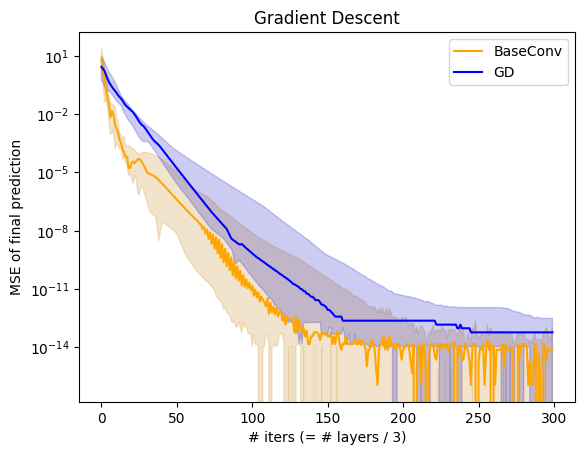

Final error: 7.105427357601002e-15


In [10]:
# Manually pass through model
out_seq = model._read_in(in_seq)
initial_input = out_seq.clone()

# Init w_hat guess
out_seq[:, :, n_dims+1:2*n_dims+1] = x_init[:, None, :]

preds = []
pred_xs = []
data_deviations = []

for iter_i in range(num_iters):
    out_seq = model._backbone.transformer.h[0](out_seq)
    out_seq = model._backbone.transformer.h[1](out_seq)
    out_seq = model._backbone.transformer.h[2](out_seq)

    # How much has the initial data deviated?
    data_deviation = (initial_input - out_seq)[0, :, :n_dims+1].norm(dim=-1).square().mean().item()
    data_deviations.append(data_deviation)

    pred_w = out_seq[:, -1, n_dims+1:2*n_dims+1].clone().detach()

    if iter_i < 1:
        print(f"Iter {iter_i}: w_hat = {pred_w[0]}")
        print(f"Iter {iter_i}: data deviation = {data_deviation}")

    pred = einsum(pred_w, a[:, -1], "b d, b d -> b")
    preds.append(pred)
    pred_xs.append(pred_w.clone())

preds = torch.stack(preds, dim=0) # (num_iters, B)
pred_xs = torch.stack(pred_xs, dim=0) # (num_iters, B, D)
errors = ((preds - b[:, -1])**2).detach().cpu().numpy() # (num_iters, B)
errors_baseconv_25 = np.percentile(errors, 25, axis=1)
errors_baseconv_75 = np.percentile(errors, 75, axis=1)
errors_baseconv = np.median(errors, axis=1)

# Colors
color_baseconv = mcolors.rgb_to_hsv(mcolors.to_rgb('orange'))
color_gd = mcolors.rgb_to_hsv(mcolors.to_rgb('blue'))

# Plot
# BaseConv
plt.plot(errors_baseconv, label="BaseConv", color="orange")
plt.fill_between(list(range(len(errors_baseconv))), errors_baseconv_25, errors_baseconv_75, alpha=0.2, color=adjust_lightness(color_baseconv, lightness=0.75))
# GD
plt.plot(errors_gd, label="GD", color="blue")
plt.fill_between(list(range(len(errors_gd))), errors_gd_25, errors_gd_75, alpha=0.2, color=adjust_lightness(color_gd, lightness=0.75))
plt.title("Gradient Descent")
plt.yscale("log")
plt.xlabel("# iters (= # layers / 3)")
plt.ylabel("MSE of final prediction")
plt.legend()
plt.show()

print(f"Final error: {errors_baseconv[-1].item()}")